### Image segmentation (road segmentation)

Steps:

1. Download model using 01_model_downloader.ipynb named "road-segmentation-adas-0001"

2. Detail about the model:

https://docs.openvinotoolkit.org/latest/omz_models_intel_road_segmentation_adas_0001_description_road_segmentation_adas_0001.html

-> In summary, details are:

* Model is trained using PyTorch but converted to IR format. 
* Input image size - 512x896 (HxW)
* Channel order - BGR
* Output size - 1x4x512x896 (4 classes in total = BG, road, curb, mark) 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#### Define parameters

In [3]:
# Parameters
IMG_FPATH = "./images/road1.jpg" # or, road2.jpg
MODEL_FPATH = "./models/intel/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.bin"
ARCH_FPATH = "./models/intel/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml"

#### Load image and create a blob

In [4]:
# Read an image.
img = cv2.imread(IMG_FPATH)
if img is None:
    raise Exception('Image not found!')
    
# Prepare input blob and perform inference
blob = cv2.dnn.blobFromImage(img, size=(896, 512), ddepth=cv2.CV_8U)

print(blob.shape)

(1, 3, 512, 896)


#### Load model and run inference 

In [5]:
# Load the model.
net = cv2.dnn.readNet(MODEL_FPATH, ARCH_FPATH)

# Specify target device.
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Run Inference
net.setInput(blob)
out = net.forward()

# Get number classes and spatial dimensions
(num_classes, height, width) = out.shape[1:4]

#### Create class ID to color code 

In [6]:
# it maps class ID to a color code which can be used to image segmentation visualization
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(num_classes - 1, 3), dtype="uint8")
COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")

#### Display segmentation results overlapped with original image

In [7]:
def show_img(img):
    dpi = 80
    height, width, _ = img.shape
    figsize = width / float(dpi), height / float(dpi)
    
    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

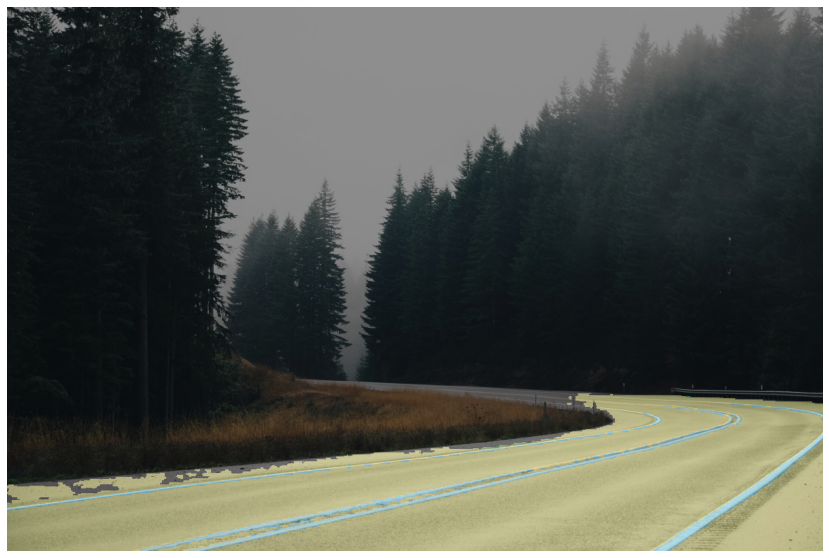

In [8]:
# Get class ids which is argmax for the class label with the highest probs.
classIds = np.argmax(out[0], axis=0)
segment_map = COLORS[classIds]
segment_map = cv2.resize(segment_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# mix original with segmentation map
img = (0.4 * segment_map + 0.6 * img).astype(np.uint8)
show_img(img)